In [1]:
# You can run the explainers locally
from explainers_lib.explainers.wachter import WachterExplainer
from explainers_lib.explainers.growing_spheres import GrowingSpheresExplainer

# Or you can run it via celery, or even run some locally and some via celery
# from explainers_lib.explainers.celery_explainer import WachterExplainer
# from explainers_lib.explainers.celery_explainer import GrowingSpheresExplainer
from explainers_lib.explainers.celery_explainer import ActionableRecourseExplainer
from explainers_lib.explainers.celery_explainer import FaceExplainer
from explainers_lib.explainers.celery_explainer import DiceExplainer
from explainers_lib.explainers.celery_explainer import AlibiCFProto
from explainers_lib.explainers.celery_explainer import AlibiCFRL

# To do this, start the redis message broker
# docker run -d -p 6379:6379 --name celery-redis redis

# Then start the explainers (you need to have properly configured python venv)
# celery -A explainers.wachter.main worker -l info -n wachter_worker@%h -Q wachter,celery
# celery -A explainers.growing_spheres.main worker -l info -n growing_spheres_worker@%h -Q growing_spheres,celery

# If you prefer to use Docker, you can pull the images from our repository
# docker pull cfe.cs.put.poznan.pl/counterfactuals-wachter
# docker pull cfe.cs.put.poznan.pl/counterfactuals-growing-spheres

# Alternatively you can build and run the images
# docker build -t wachter-explainer -f explainers/wachter/Dockerfile .
# docker build -t growing-spheres-explainer -f explainers/growing_spheres/Dockerfile .
# docker run --rm -it --network host wachter-explainer
# docker run --rm -it --network host growing-spheres-explainer

from explainers_lib.aggregators import Pareto
from explainers_lib.datasets import Dataset
from explainers_lib.ensemble import Ensemble
from explainers_lib.model import TorchModel
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split

# Dataset preparation
iris = load_iris()

data = pd.DataFrame(data=iris.data, columns=iris.feature_names)
data["species"] = iris.target

label_encoder = LabelEncoder()
data["species"] = label_encoder.fit_transform(data["species"])

X = data.drop("species", axis=1).values
y = data["species"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

data = Dataset(X_test, y_test, iris.feature_names, [], iris.feature_names, [], [])

# Loading the pretrained model
with open("/home/berni/education/counterfactuals/examples/temp_model.pt", "rb") as f:
    model_data = f.read()

model = TorchModel.deserialize(model_data)

# Ensemble
ensemble = Ensemble(
    model,
    [WachterExplainer(), GrowingSpheresExplainer(),                   # Local explainers
     ActionableRecourseExplainer(), DiceExplainer(), FaceExplainer(), # Carla explainers
     AlibiCFProto(), AlibiCFRL()],                                    # Alibi explainers
    Pareto())
print(f"Used celery explainers: {[explainer.explainer_name for explainer in ensemble.celery_explainers]}")

ensemble.fit(data)
print(f"Ensemble fitting complete")

cfs = ensemble.explain(data[:5],
                       pretty_print=True,
                       pretty_print_postprocess=scaler.inverse_transform,
                       pretty_print_postprocess_target=label_encoder.inverse_transform)
print(f"Number of generated cfs: {len(cfs)}")


Used celery explainers: ['carla_actionable_recourse', 'carla_dice', 'carla_face', 'alibi_cfproto', 'alibi_cfrl']
Ensemble fitting complete


5instance [00:00, 20.64instance/s]
5instance [00:09,  1.94s/instance]


┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ sepal length (cm) ┃ sepal width (cm) ┃ petal length (cm) ┃ petal width (cm) ┃ target ┃ source                   ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            6.0000 │           2.9000 │            4.5000 │           1.5000 │      1 │ original data            │
│               N/A │              N/A │               N/A │              N/A │    N/A │ actionable_recourse(fli… │
│               N/A │              N/A │               N/A │              N/A │    N/A │ cfproto()                │
│            6.2451 │           3.2214 │            4.7061 │           1.5684 │      1 │ cfrl(latent_dim=2,       │
│                   │                  │                   │                  │        │ coeff_sparsity=0.5,      │
│                   │                  │                   │                  │        │ coeff_consistency=0.5,   │
│                   │                  │                   │                  │        │ train_steps=3,           │
│                   │                  │                   │                  │        │ batch_size=10)           │
│               N/A │              N/A │               N/A │              N/A │    N/A │ dice_explainer(num_cfs=… │
│                   │                  │                   │                  │        │ method='random')         │
│               N/A │              N/A │               N/A │              N/A │    N/A │ face_explainer(mode=knn, │
│                   │                  │                   │                  │        │ fraction=0.05,           │
│                   │                  │                   │                  │        │ n_neighbors=50)          │
│            6.0433 │           2.9216 │            5.0680 │           1.6657 │      2 │ growing_spheres(step_si… │
│                   │                  │                   │                  │        │ max_radius=5.0,          │
│                   │                  │                   │                  │        │ num_samples=1000)        │
│            5.3664 │           3.4713 │            4.5000 │           0.0193 │      0 │ wachter(lambda_param=0.… │
│                   │                  │                   │                  │        │ random_seed=None)        │
├───────────────────┼──────────────────┼───────────────────┼──────────────────┼────────┼──────────────────────────┤
│            6.1000 │           2.8000 │            4.7000 │           1.2000 │      1 │ original data            │
│               N/A │              N/A │               N/A │              N/A │    N/A │ actionable_recourse(fli… │
│               N/A │              N/A │               N/A │              N/A │    N/A │ cfproto()                │
│            6.2431 │           3.2235 │            4.7040 │           1.5697 │      1 │ cfrl(latent_dim=2,       │
│                   │                  │                   │                  │        │ coeff_sparsity=0.5,      │
│                   │                  │                   │                  │        │ coeff_consistency=0.5,   │
│                   │                  │                   │                  │        │ train_steps=3,           │
│                   │                  │                   │                  │        │ batch_size=10)           │
│               N/A │              N/A │               N/A │              N/A │    N/A │ dice_explainer(num_cfs=… │
│                   │                  │                   │                  │        │ method='random')         │
│               N/A │              N/A │               N/A │              N/A │    N/A │ face_explainer(mode=knn, │
│                   │                  │                   │                  │        │ fraction=0.05,           │
│                   │                  │                

Number of generated cfs: 12


/home/berni/education/counterfactuals/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1/1 [00:00<00:00, 145.29it/s]


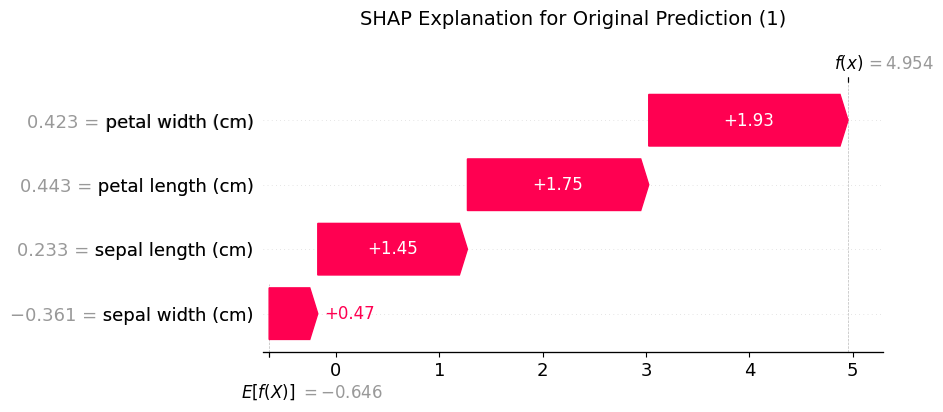

100%|██████████| 1/1 [00:00<00:00, 480.94it/s]


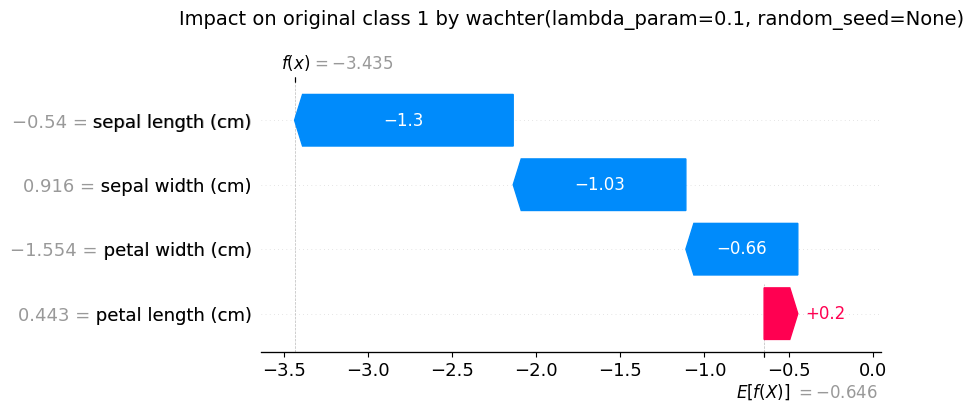

100%|██████████| 1/1 [00:00<00:00, 144.02it/s]


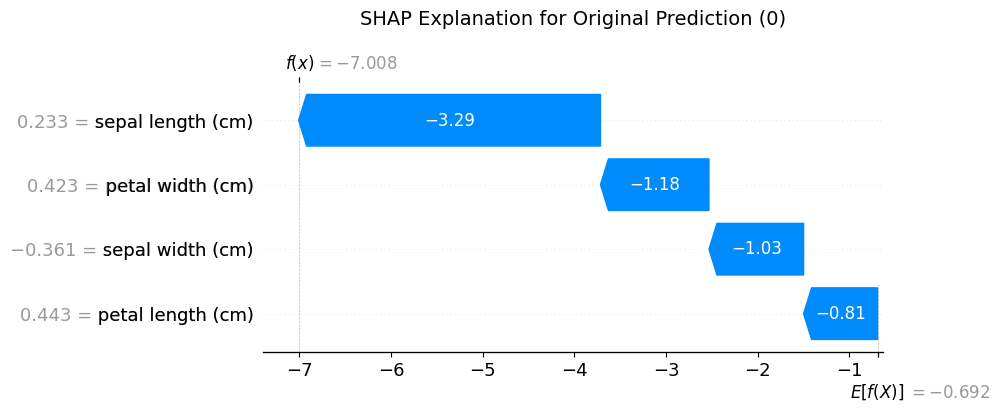

100%|██████████| 1/1 [00:00<00:00, 63.93it/s]


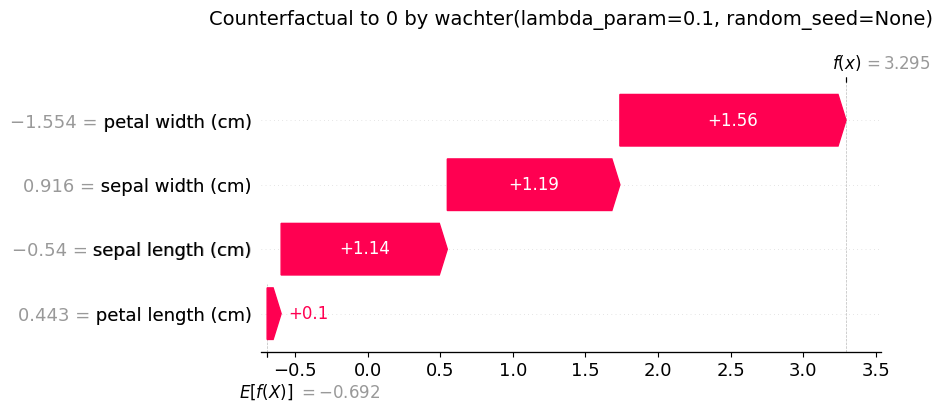

100%|██████████| 1/1 [00:00<00:00, 132.15it/s]


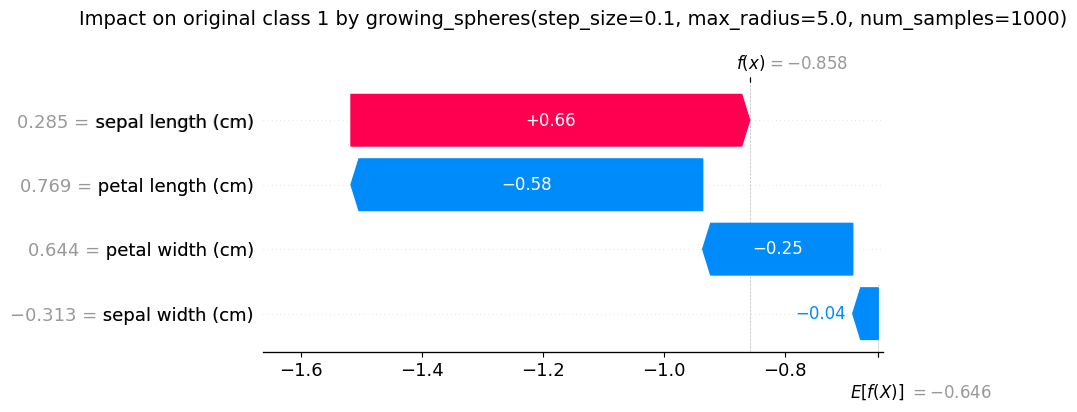

100%|██████████| 1/1 [00:00<00:00, 29.47it/s]


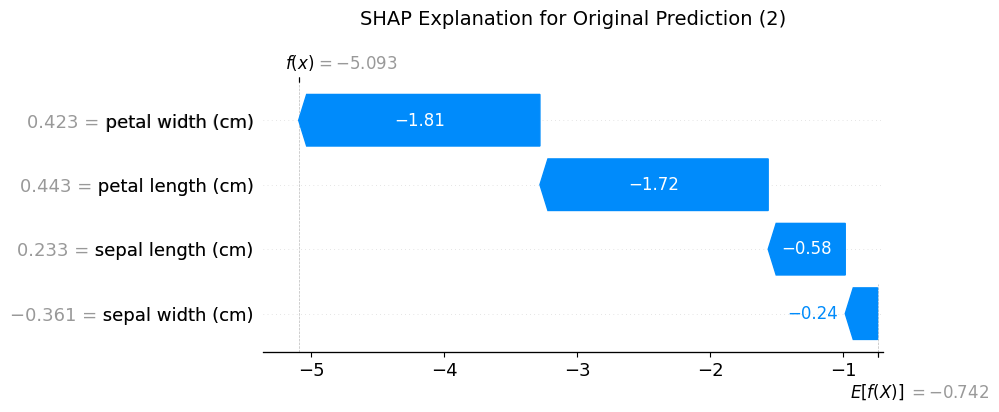

100%|██████████| 1/1 [00:00<00:00, 72.76it/s]


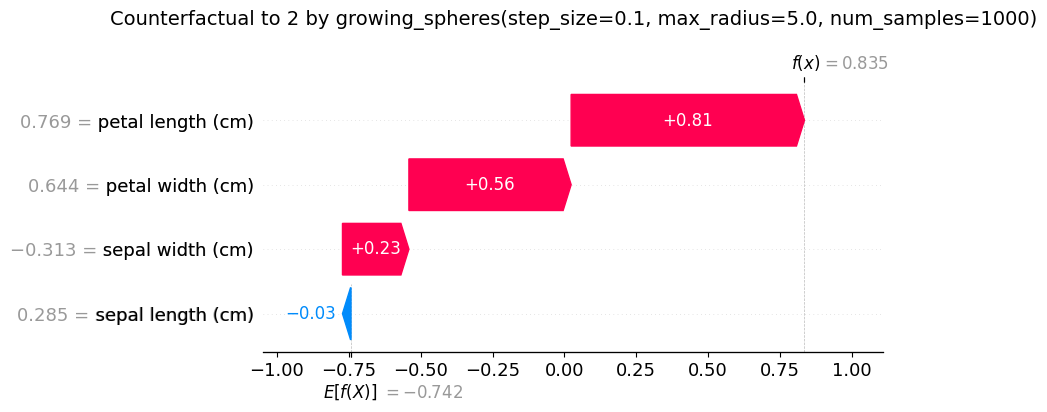

100%|██████████| 1/1 [00:00<00:00, 87.41it/s]


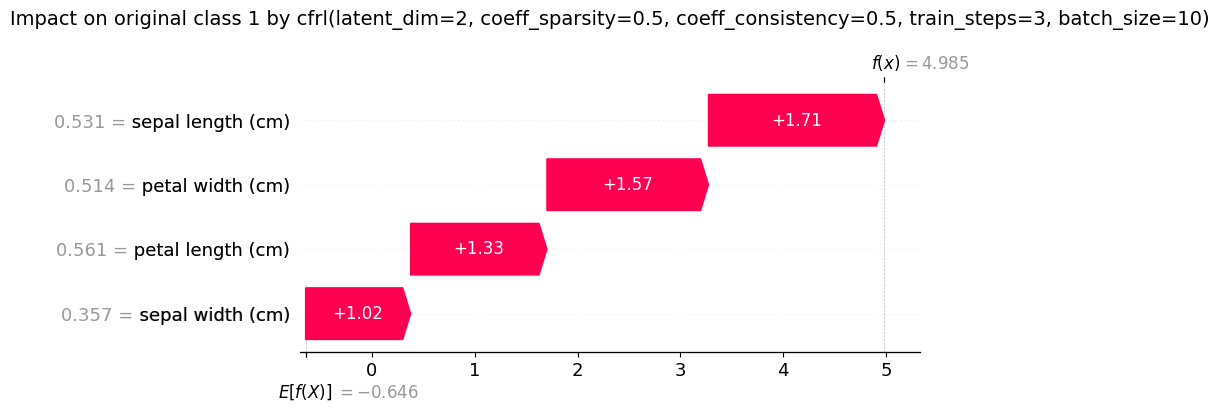

100%|██████████| 1/1 [00:00<00:00, 386.50it/s]


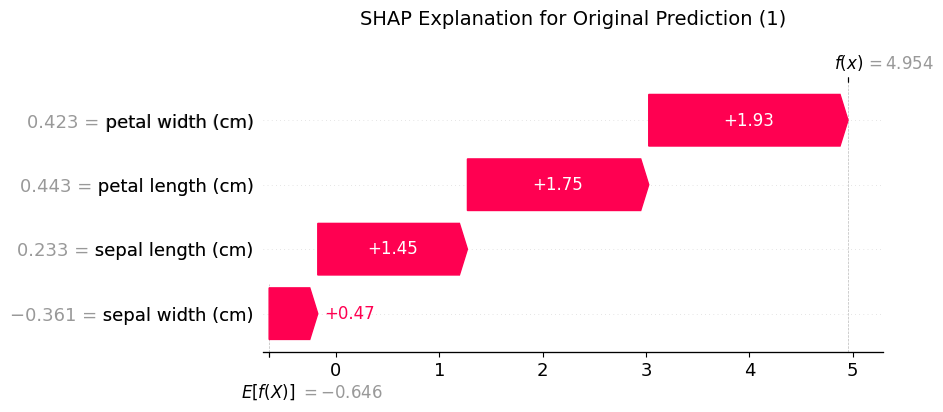

100%|██████████| 1/1 [00:00<00:00, 180.09it/s]


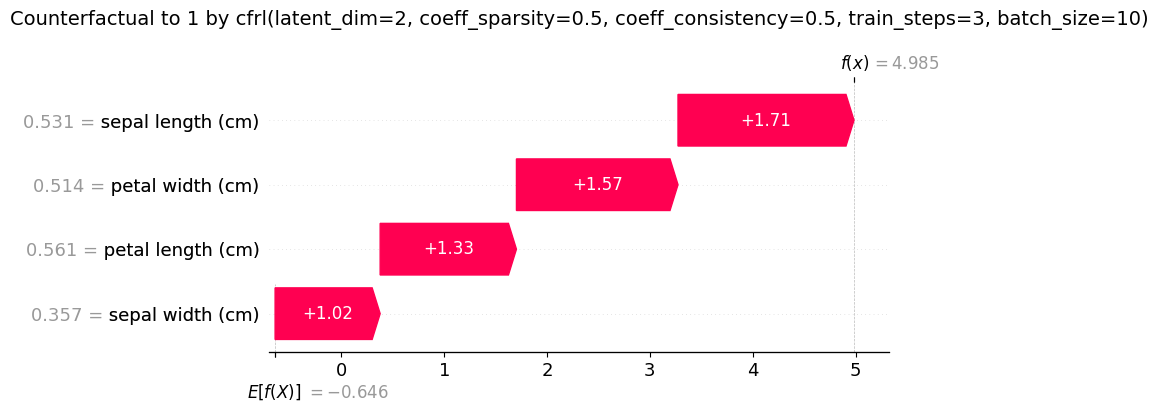

100%|██████████| 1/1 [00:00<00:00, 40.49it/s]


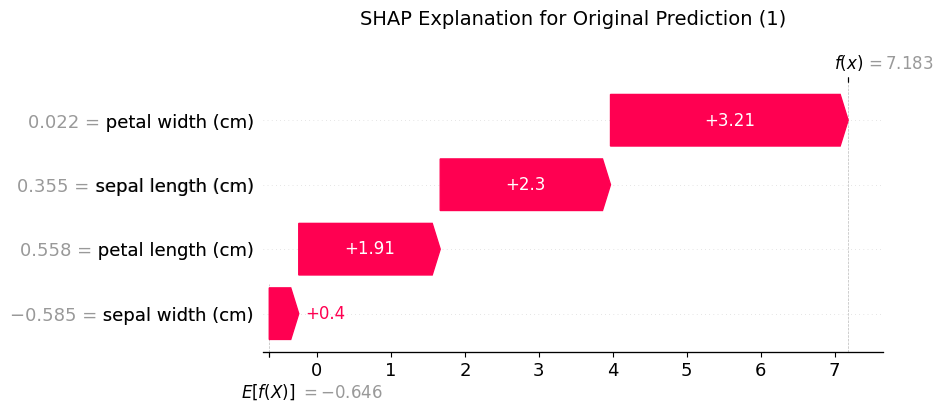

100%|██████████| 1/1 [00:00<00:00, 261.95it/s]


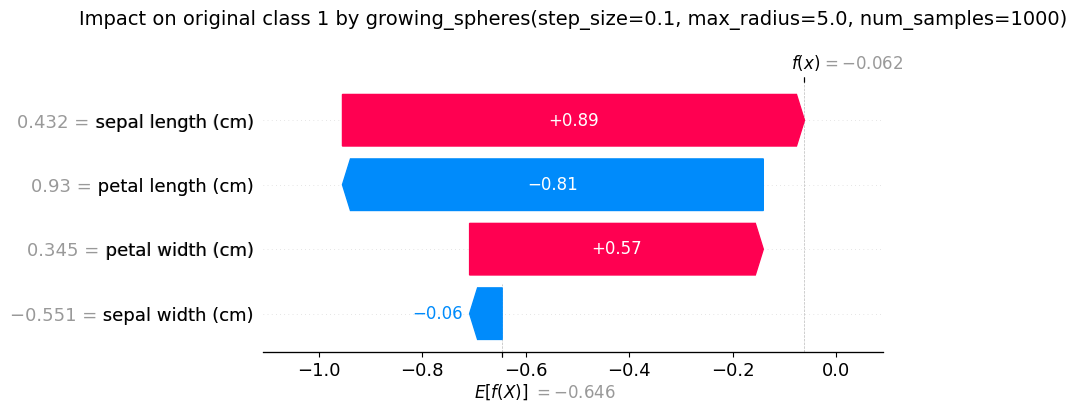

100%|██████████| 1/1 [00:00<00:00, 38.87it/s]


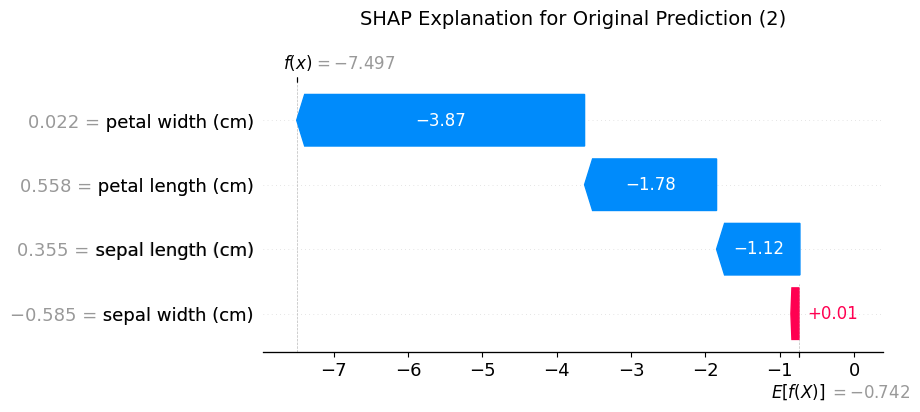

100%|██████████| 1/1 [00:00<00:00, 121.82it/s]


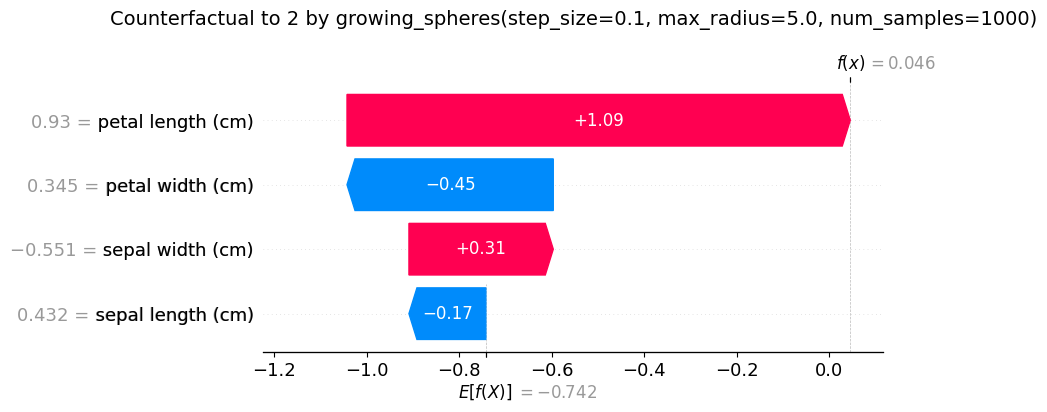

100%|██████████| 1/1 [00:00<00:00, 426.68it/s]


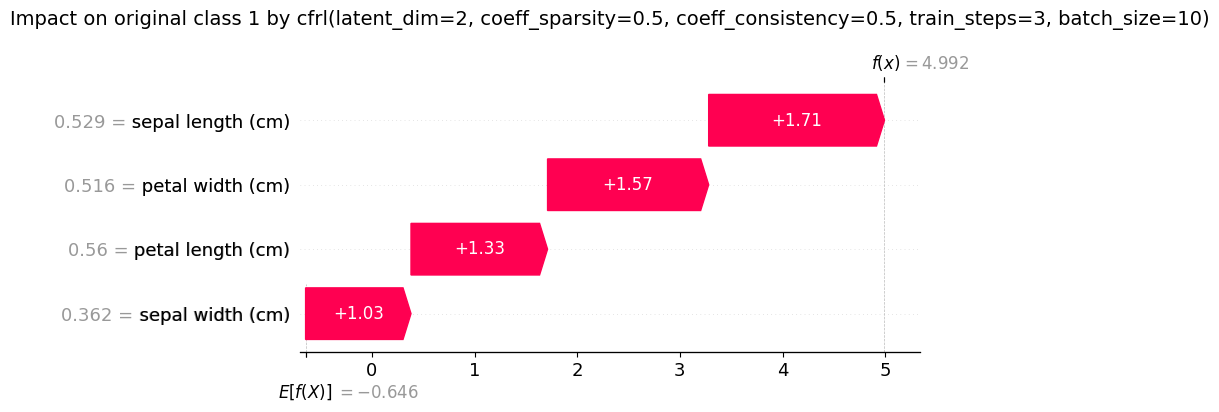

100%|██████████| 1/1 [00:00<00:00, 338.63it/s]


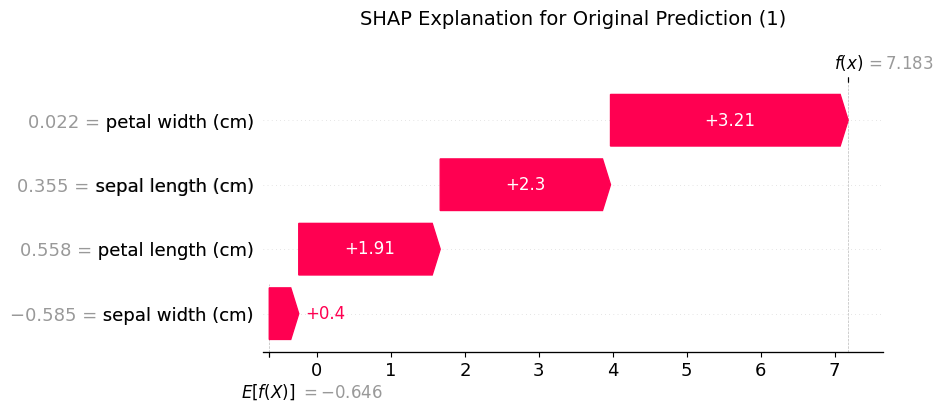

100%|██████████| 1/1 [00:00<00:00, 239.76it/s]


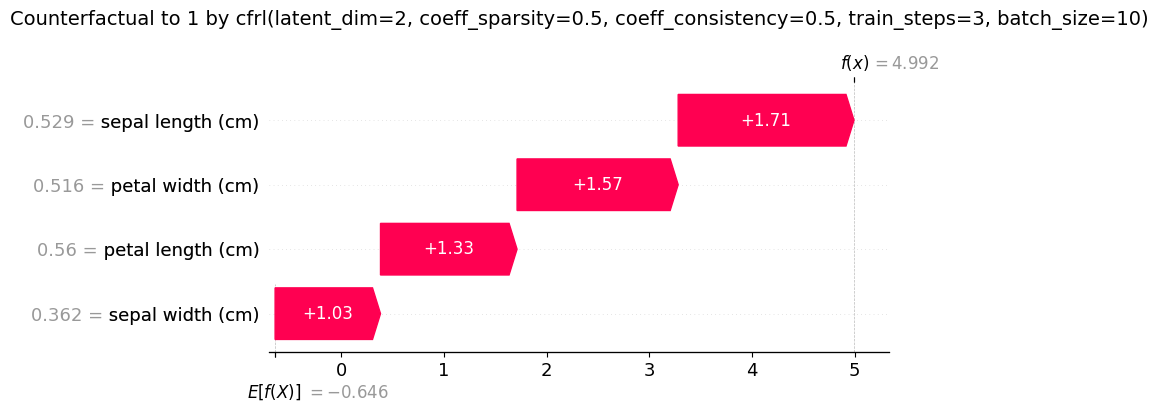

100%|██████████| 1/1 [00:00<00:00, 91.70it/s]


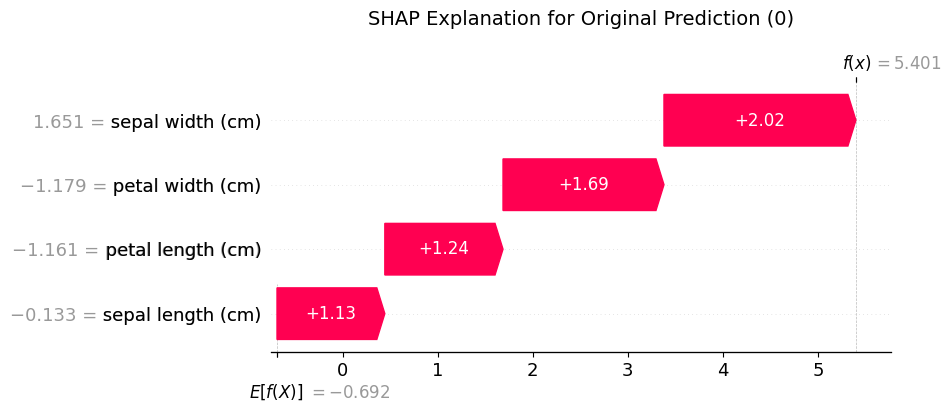

100%|██████████| 1/1 [00:00<00:00, 150.01it/s]


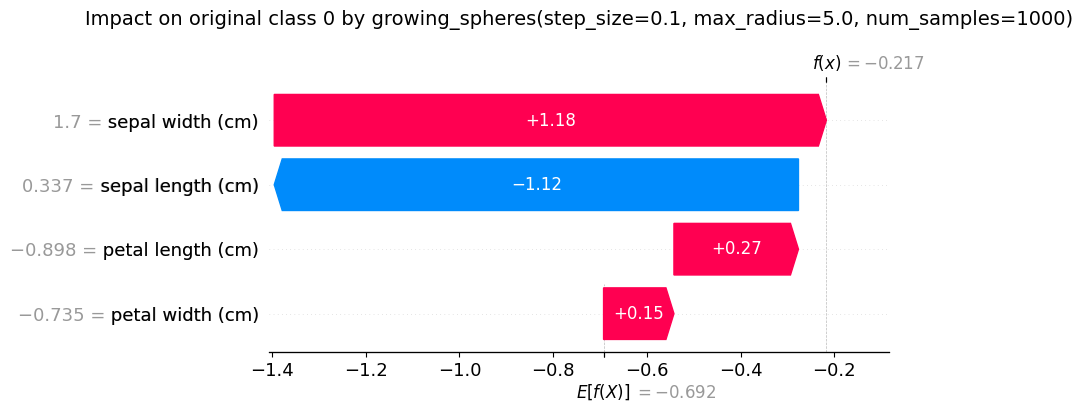

100%|██████████| 1/1 [00:00<00:00, 321.45it/s]


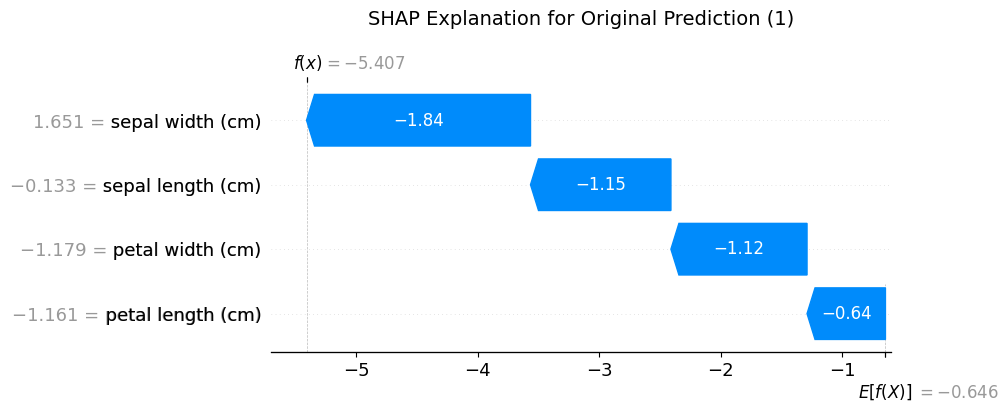

100%|██████████| 1/1 [00:00<00:00, 111.05it/s]


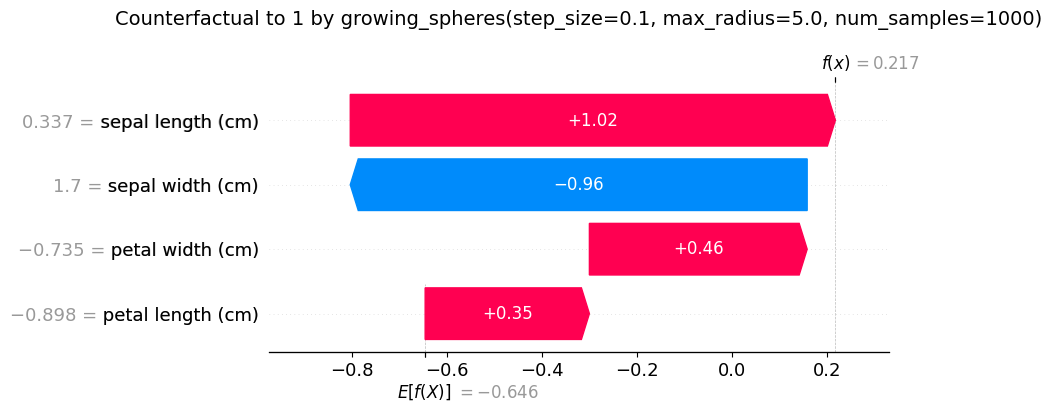

100%|██████████| 1/1 [00:00<00:00, 472.12it/s]


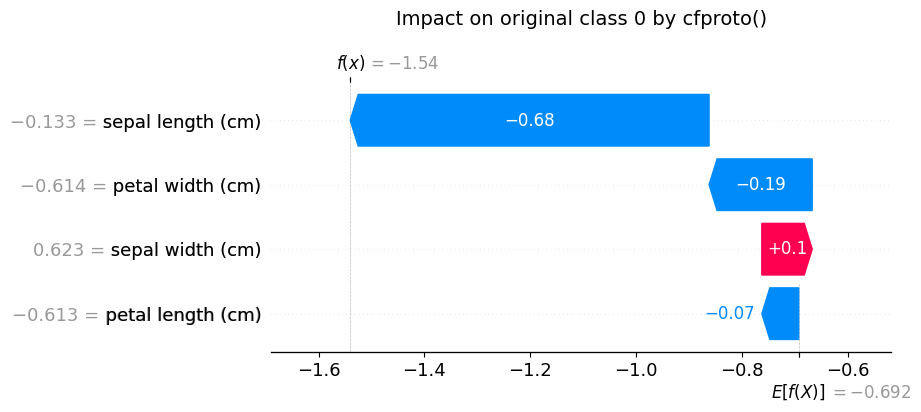

100%|██████████| 1/1 [00:00<00:00, 264.83it/s]


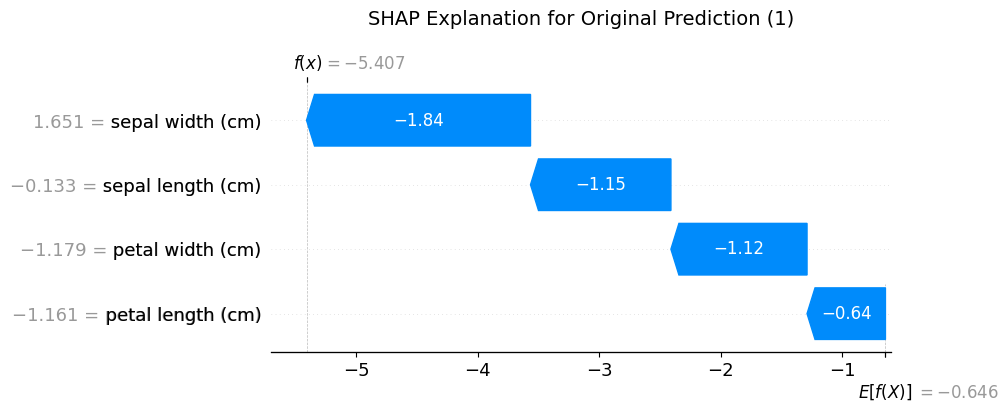

100%|██████████| 1/1 [00:00<00:00, 191.85it/s]


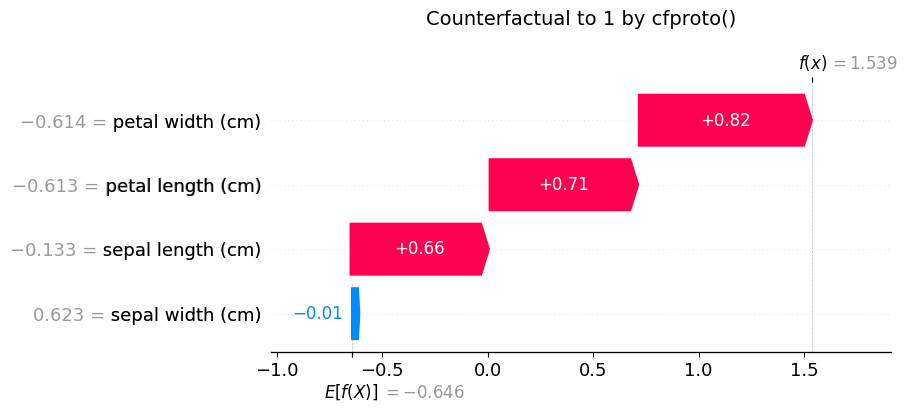

100%|██████████| 1/1 [00:00<00:00, 52.46it/s]


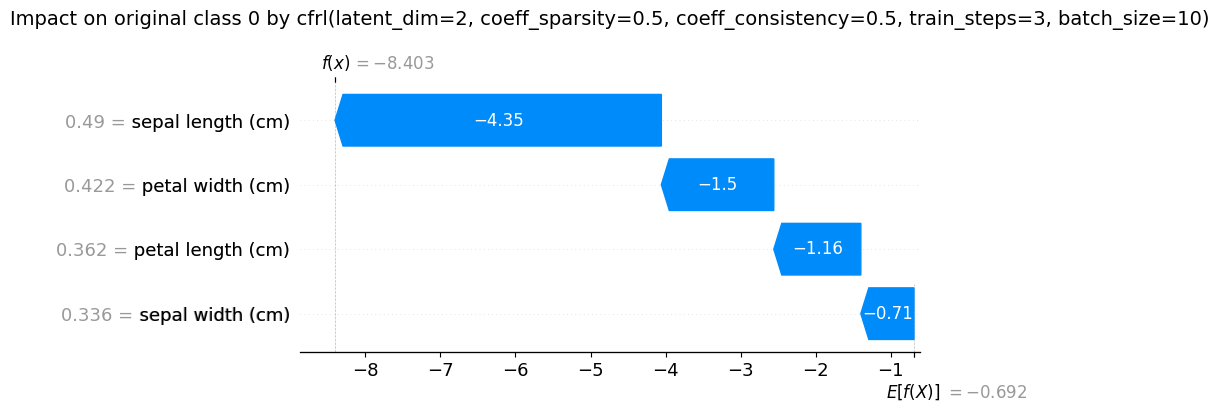

100%|██████████| 1/1 [00:00<00:00, 123.73it/s]


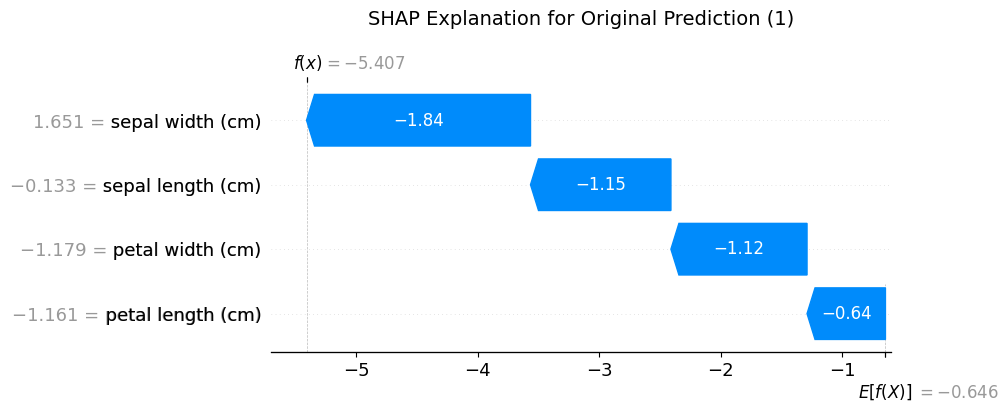

100%|██████████| 1/1 [00:00<00:00, 72.94it/s]


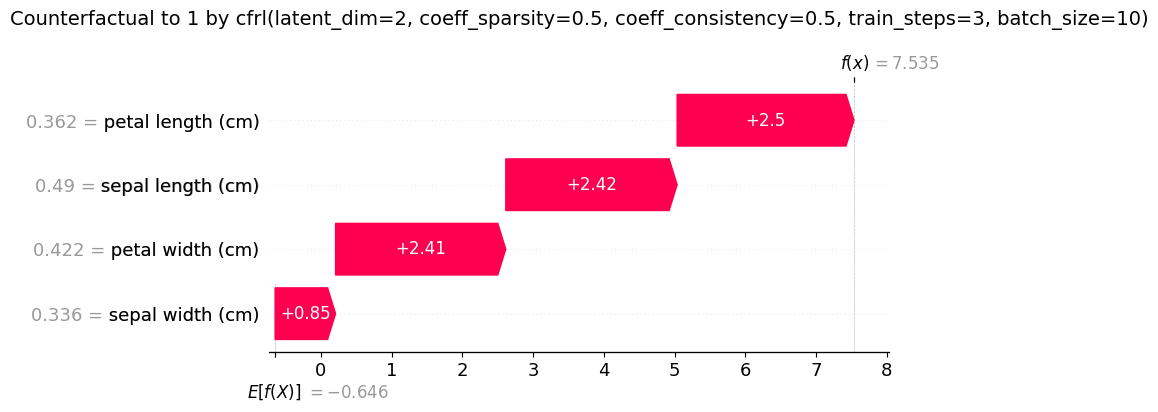

100%|██████████| 1/1 [00:00<00:00, 299.64it/s]


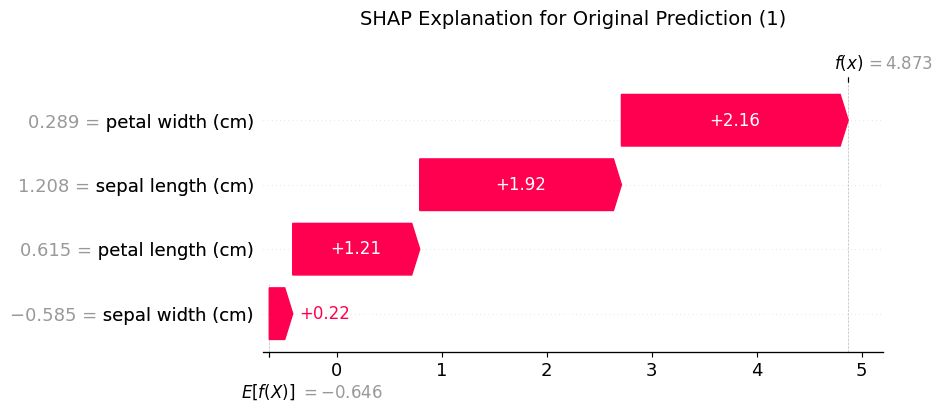

100%|██████████| 1/1 [00:00<00:00, 60.83it/s]


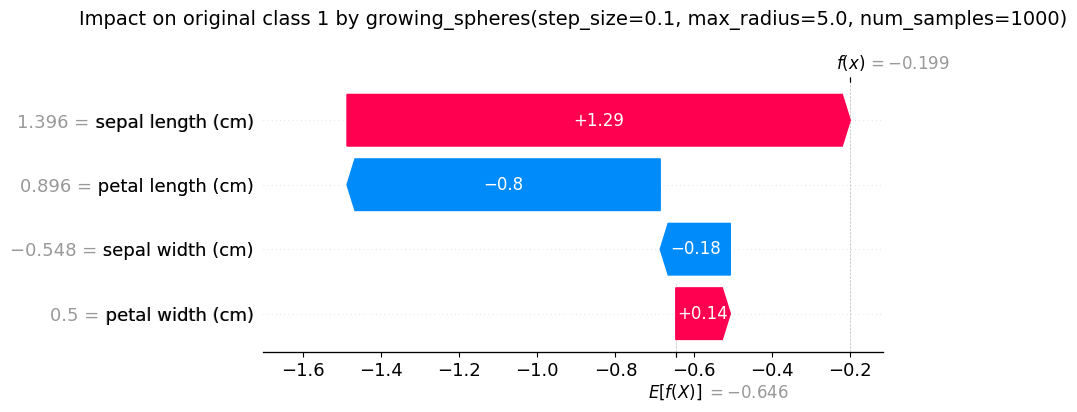

100%|██████████| 1/1 [00:00<00:00, 71.18it/s]


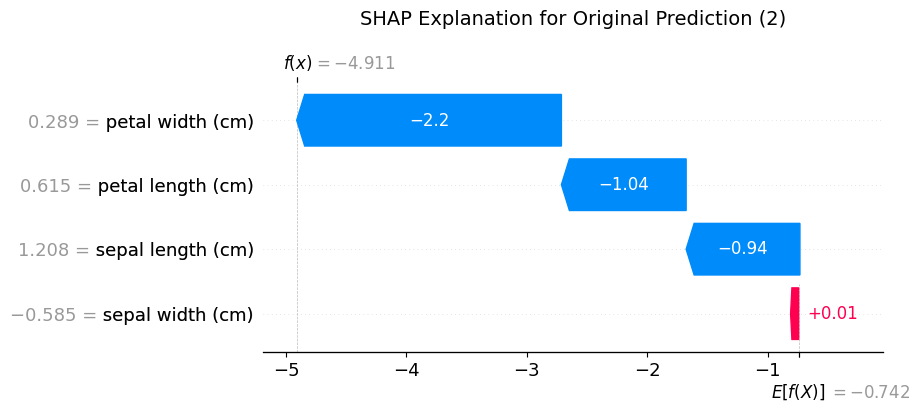

100%|██████████| 1/1 [00:00<00:00, 452.95it/s]


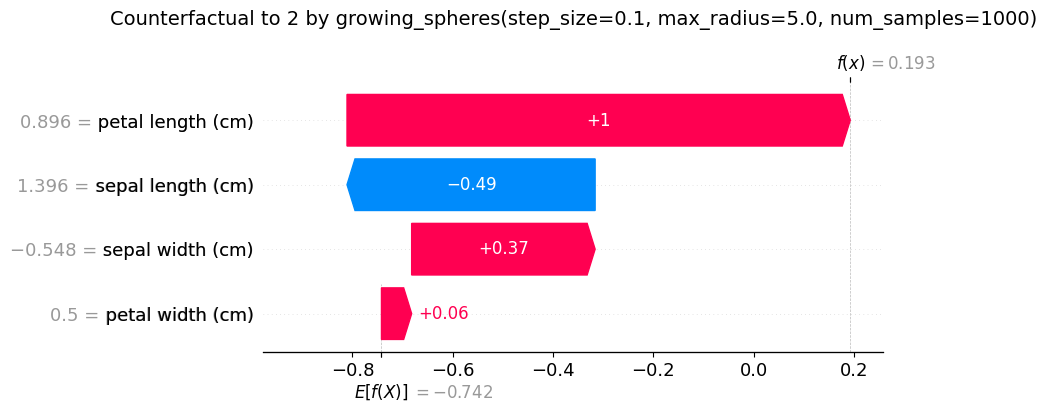

100%|██████████| 1/1 [00:00<00:00, 442.44it/s]


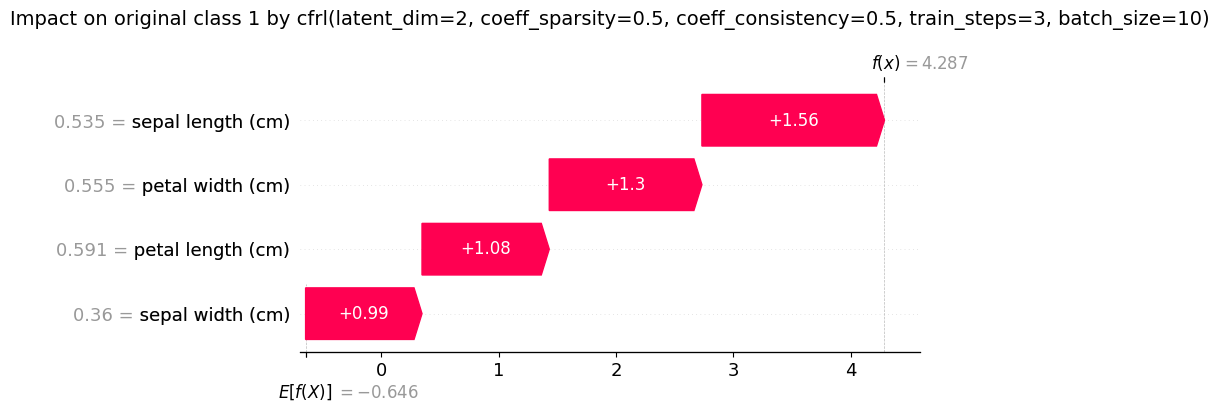

100%|██████████| 1/1 [00:00<00:00, 129.74it/s]


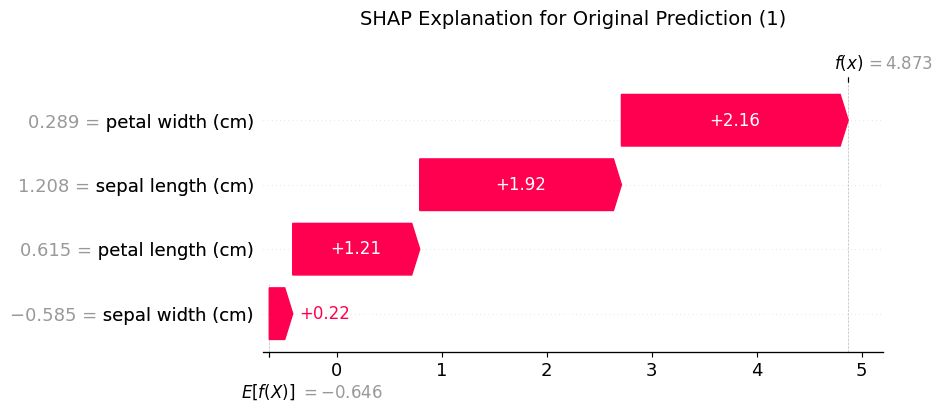

100%|██████████| 1/1 [00:00<00:00, 450.66it/s]


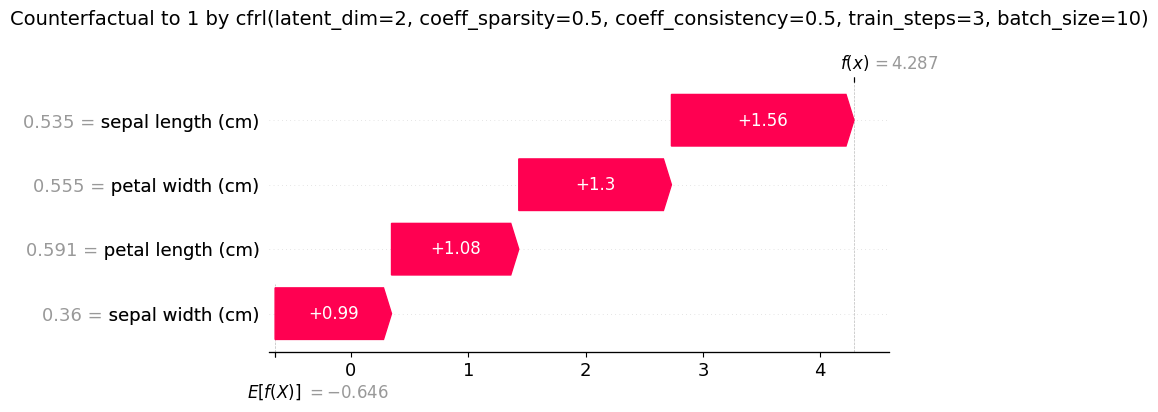

100%|██████████| 1/1 [00:00<00:00, 267.26it/s]


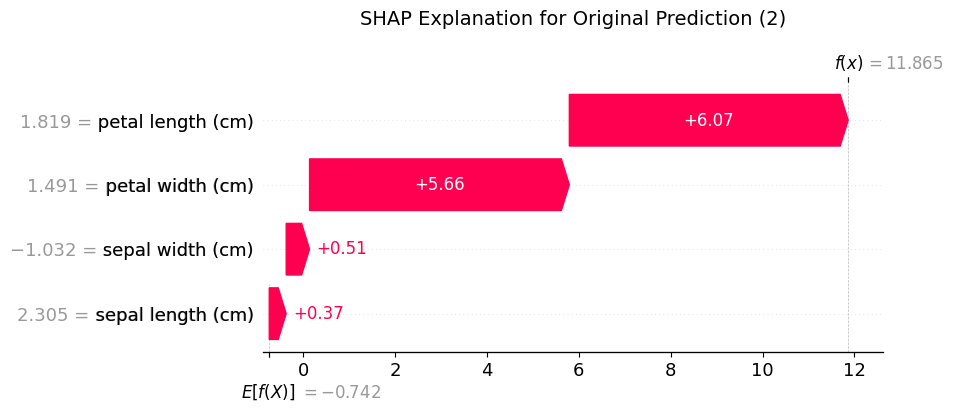

100%|██████████| 1/1 [00:00<00:00, 417.43it/s]


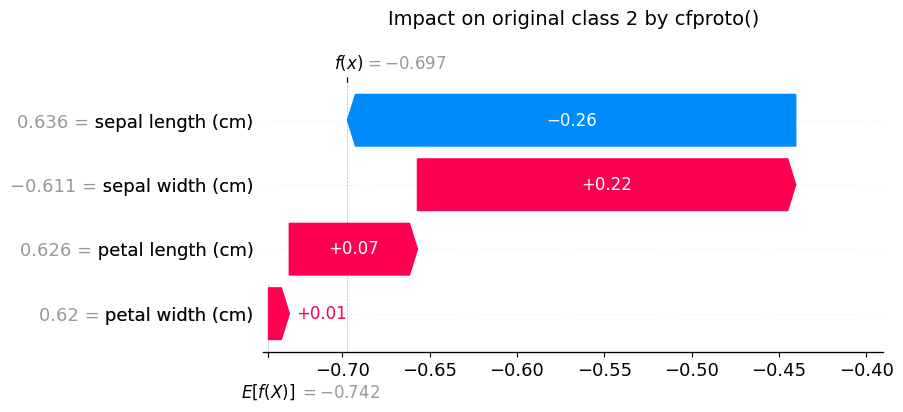

100%|██████████| 1/1 [00:00<00:00, 438.83it/s]


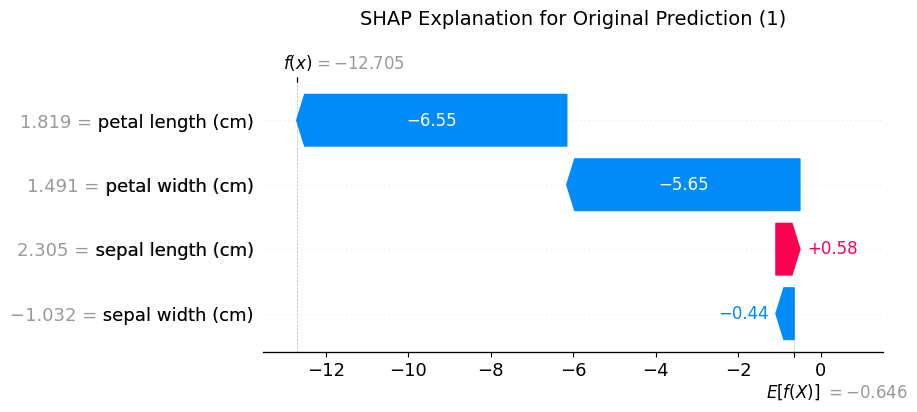

100%|██████████| 1/1 [00:00<00:00, 59.39it/s]


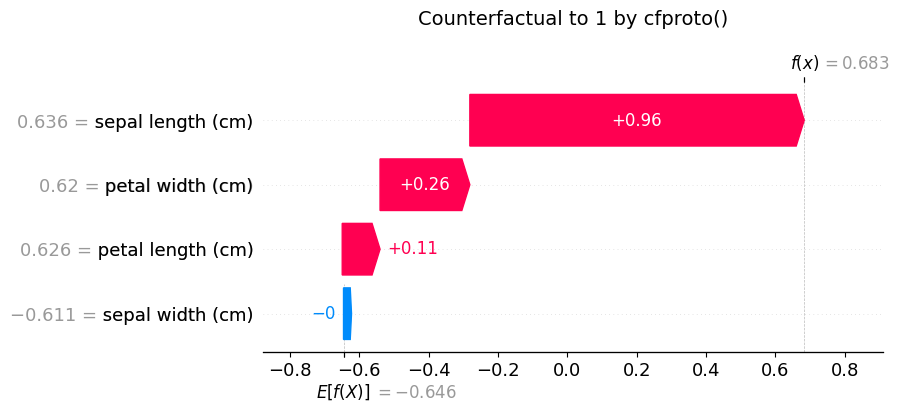

100%|██████████| 1/1 [00:00<00:00, 210.82it/s]


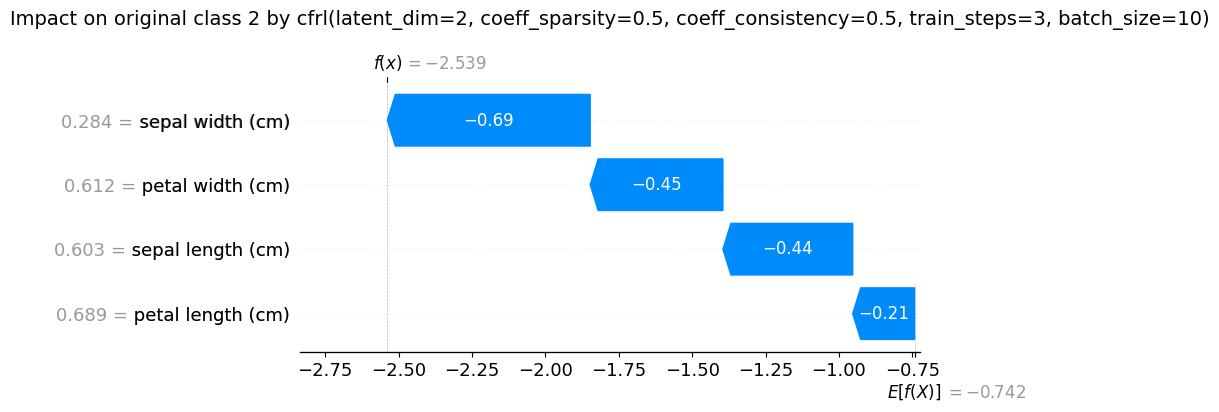

100%|██████████| 1/1 [00:00<00:00, 77.68it/s]


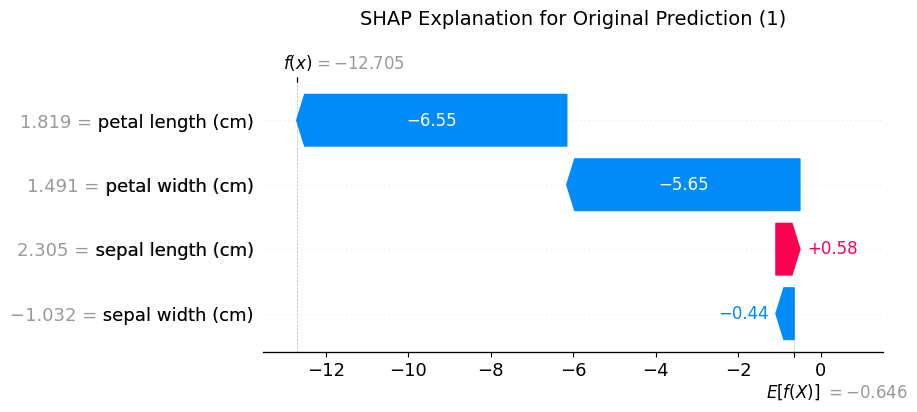

100%|██████████| 1/1 [00:00<00:00, 479.08it/s]


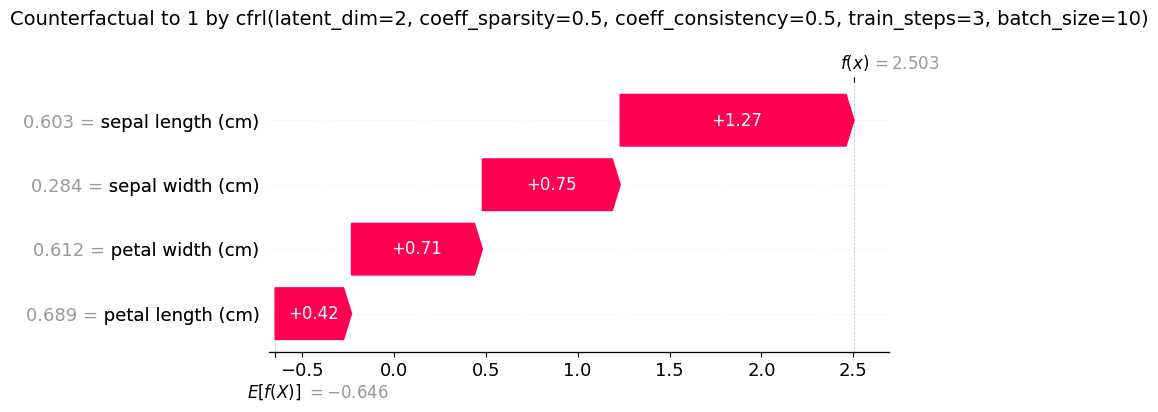

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import shap
from collections import defaultdict

background_summary = shap.kmeans(X_train, 10)

def predict_class_0(x):
    return model.predict_proba(x)[:, 0]
def predict_class_1(x):
    return model.predict_proba(x)[:, 1]
def predict_class_2(x):
    return model.predict_proba(x)[:, 2]

explainers = [
    shap.KernelExplainer(predict_class_0, background_summary, link="logit"),
    shap.KernelExplainer(predict_class_1, background_summary, link="logit"),
    shap.KernelExplainer(predict_class_2, background_summary, link="logit"),
]

grouped_cfs = defaultdict(list)
for cf in cfs:
    key = cf.original_data.tobytes()
    grouped_cfs[key].append(cf)

for original_data_bytes, cfs_for_source in grouped_cfs.items():
    original_data = np.frombuffer(original_data_bytes, dtype=np.float64).reshape(1, -1)
    original_class = cfs_for_source[0].original_class
    original_class_name = label_encoder.inverse_transform([original_class])[0]

    plt.figure(figsize=(10, 6))
    explainer_orig = explainers[original_class]
    shap_values_orig = explainer_orig.shap_values(original_data)
    
    explanation_orig = shap.Explanation(
        values=shap_values_orig[0],
        base_values=explainer_orig.expected_value,
        data=original_data[0],
        feature_names=iris.feature_names
    )
    plt.title(f"SHAP Explanation for Original Prediction ({original_class_name})", fontsize=14, pad=20)
    shap.plots.waterfall(explanation_orig, max_display=10, show=True)

    for cf in cfs_for_source:
        plt.figure(figsize=(10, 6))
        x_cf = cf.data.reshape(1, -1)
        target_class = cf.target_class

        explainer_cf = explainers[original_class]
        shap_values_cf = explainer_cf.shap_values(x_cf)

        explanation_cf = shap.Explanation(
            values=shap_values_cf[0],
            base_values=explainer_cf.expected_value,
            data=x_cf[0],
            feature_names=iris.feature_names
        )
        target_class_name = label_encoder.inverse_transform([target_class])[0]
        plt.title(f"Impact on original class {original_class_name} by {cf.explainer}", fontsize=14, pad=20)
        shap.plots.waterfall(explanation_cf, max_display=10, show=True)

# --
        plt.figure(figsize=(10, 6))
        explainer_orig = explainers[target_class]
        shap_values_orig = explainer_orig.shap_values(original_data)
        
        explanation_orig = shap.Explanation(
            values=shap_values_orig[0],
            base_values=explainer_orig.expected_value,
            data=original_data[0],
            feature_names=iris.feature_names
        )
        plt.title(f"SHAP Explanation for Original Prediction ({target_class_name})", fontsize=14, pad=20)
        shap.plots.waterfall(explanation_orig, max_display=10, show=True)



        plt.figure(figsize=(10, 6))
        x_cf = cf.data.reshape(1, -1)
        target_class = cf.target_class

        explainer_cf = explainers[target_class]
        shap_values_cf = explainer_cf.shap_values(x_cf)

        explanation_cf = shap.Explanation(
            values=shap_values_cf[0],
            base_values=explainer_cf.expected_value,
            data=x_cf[0],
            feature_names=iris.feature_names
        )
        target_class_name = label_encoder.inverse_transform([target_class])[0]
        plt.title(f"Counterfactual to {target_class_name} by {cf.explainer}", fontsize=14, pad=20)
        shap.plots.waterfall(explanation_cf, max_display=10, show=True)

